In [15]:
%matplotlib inline


# Light curves for flares

Compute the light curve of a PKS 2155-304 flare on 10 minutes time intervals.

## Prerequisites

-  Understanding of how the light curve estimator works, please refer to
   the :doc:`light curve notebook </tutorials/analysis-time/light_curve`.

## Context

Frequently, especially when studying flares of bright sources, it is
necessary to explore the time behaviour of a source on short time
scales, in particular on time scales shorter than observing runs.

A typical example is given by the flare of PKS 2155-304 during the night
from July 29 to 30 2006. See the [following
article](https://ui.adsabs.harvard.edu/abs/2009A%26A...502..749A/abstract)_.

**Objective: Compute the light curve of a PKS 2155-304 flare on 5
minutes time intervals, i.e. smaller than the duration of individual
observations.**

## Proposed approach

We have seen in the general presentation of the light curve estimator,
see the :doc:`light curve notebook </tutorials/analysis-time/light_curve>`, Gammapy produces
datasets in a given time interval, by default that of the parent
observation. To be able to produce datasets on smaller time steps, it is
necessary to split the observations into the required time intervals.

This is easily performed with the `~gammapy.data.Observations.select_time` method of
`~gammapy.data.Observations`. If you pass it a list of time intervals
it will produce a list of time filtered observations in a new
`~gammapy.data.Observations` object. Data reduction can then be
performed and will result in datasets defined on the required time
intervals and light curve estimation can proceed directly.

In summary, we have to:

-  Select relevant `~gammapy.data.Observations` from the
   `~gammapy.data.DataStore`
-  Apply the time selection in our predefined time intervals to obtain a
   new `~gammapy.data.Observations`
-  Perform the data reduction (in 1D or 3D)
-  Define the source model
-  Extract the light curve from the reduced dataset

Here, we will use the PKS 2155-304 observations from the H.E.S.S. first
public test data release. We will use time intervals of 5 minutes
duration. The tutorial is implemented with the intermediate level API.

## Setup

As usual, we’ll start with some general imports…


In [3]:
import logging
import numpy as np
import astropy.units as u
from astropy.coordinates import Angle, SkyCoord
from astropy.time import Time
from regions import CircleSkyRegion

# %matplotlib inline
import matplotlib.pyplot as plt

log = logging.getLogger(__name__)

from gammapy.data import DataStore
from gammapy.datasets import Datasets, SpectrumDataset
from gammapy.estimators import LightCurveEstimator
from gammapy.makers import (
    ReflectedRegionsBackgroundMaker,
    SafeMaskMaker,
    SpectrumDatasetMaker,
)
from gammapy.maps import MapAxis, RegionGeom
from gammapy.modeling.models import PowerLawSpectralModel, SkyModel

## Select the data

We first set the datastore.




In [4]:
data_store = DataStore.from_dir("/raid/romulus/swong/LIV/mrk421_5min/")
data_store.info()

Data store:
HDU index table:
BASE_DIR: /raid/romulus/swong/LIV/mrk421_5min
Rows: 48
OBS_ID: 50099 -- 50110
HDU_TYPE: ['aeff', 'edisp', 'events', 'gti']
HDU_CLASS: ['aeff_2d', 'edisp_2d', 'events', 'gti']


Observation table:
Observatory name: 'N/A'
Number of observations: 12



In [5]:
observations = data_store.get_observations(required_irf='point-like')
print(f"Number of selected observations : {len(observations)}")

Number of selected observations : 12


In [6]:
target_position = SkyCoord(166.0791667 * u.deg, 38.1947222* u.deg, frame="icrs")
selection = dict(
    type="sky_circle",
    frame="icrs",
    lon=target_position.ra,
    lat=target_position.dec,
    radius=2 * u.deg,
)
obs_ids = data_store.obs_table.select_observations(selection)["OBS_ID"]
observations = data_store.get_observations(obs_ids,skip_missing=False,required_irf='point-like')
print(f"Number of selected observations : {len(observations)}")

Number of selected observations : 12


## Define time intervals

We create the list of time intervals. Each time interval is an
`astropy.time.Time` object, containing a start and stop time.




In [7]:
t0 = Time("2010-02-17T07:29:23.712")
duration = 5 * u.min
n_time_bins = 30
times = t0 + np.arange(n_time_bins) * duration
time_intervals = [Time([tstart, tstop]) for tstart, tstop in zip(times[:-1], times[1:])]

## Filter the observations list in time intervals

Here we apply the list of time intervals to the observations with
`~gammapy.data.Observations.select_time()`.

This will return a new list of Observations filtered by time_intervals.
For each time interval, a new observation is created that converts the
intersection of the GTIs and time interval.




In [8]:
short_observations = observations.select_time(time_intervals)
# check that observations have been filtered
print(f"Number of observations after time filtering: {len(short_observations)}\n")
print(short_observations[1].gti)

Number of observations after time filtering: 34

GTI info:
- Number of GTIs: 1
- Duration: 300.0 s
- Start: 159176065.712 s MET
- Start: 2010-02-17T07:34:23.712 (time standard: UTC)
- Stop: 159176365.712 s MET
- Stop: 2010-02-17T07:39:23.712 (time standard: UTC)



As we can see, we have now observations of duration equal to the chosen
time step.

Now data reduction and light curve extraction can proceed exactly as
before.




## Building 1D datasets from the new observations

Here we will perform the data reduction in 1D with reflected regions.

*Beware, with small time intervals the background normalization with OFF
regions might become problematic.*




### Defining the geometry

We define the energy axes. As usual, the true energy axis has to cover a
wider range to ensure a good coverage of the measured energy range
chosen.

We need to define the ON extraction region. Its size follows typical
spectral extraction regions for VERITAS analyses.




In [9]:
# Target definition
energy_axis = MapAxis.from_energy_bounds("0.11 TeV", "4 TeV", nbin=10)
energy_axis_true = MapAxis.from_energy_bounds(
    "0.11 TeV", "4 TeV", nbin=10, name="energy_true"
)

on_region_radius = Angle("0.0894427191 deg")
on_region = CircleSkyRegion(center=target_position, radius=on_region_radius)

geom = RegionGeom.create(region=on_region, axes=[energy_axis])

### Creation of the data reduction makers

We now create the dataset and background makers for the selected
geometry.




In [10]:
dataset_maker = SpectrumDatasetMaker(
    containment_correction=False, selection=["counts", "exposure", "edisp"]
)
bkg_maker = ReflectedRegionsBackgroundMaker()
safe_mask_masker = SafeMaskMaker(methods=["aeff-max"], aeff_percent=10)

### Creation of the datasets

Now we perform the actual data reduction in the time_intervals.




In [11]:
datasets = Datasets()

dataset_empty = SpectrumDataset.create(geom=geom, energy_axis_true=energy_axis_true)

for obs in short_observations:
    dataset = dataset_maker.run(dataset_empty.copy(), obs)

    dataset_on_off = bkg_maker.run(dataset, obs)
    dataset_on_off = safe_mask_masker.run(dataset_on_off, obs)
    datasets.append(dataset_on_off)

/homes/wang/swong/lib/python3.9/site-packages/gammapy/maps/geom.py:48: RuntimeWarning: invalid value encountered in cast
  p_idx = np.rint(p).astype(int)
/homes/wang/swong/lib/python3.9/site-packages/gammapy/maps/geom.py:48: RuntimeWarning: invalid value encountered in cast
  p_idx = np.rint(p).astype(int)
/homes/wang/swong/lib/python3.9/site-packages/gammapy/maps/geom.py:48: RuntimeWarning: invalid value encountered in cast
  p_idx = np.rint(p).astype(int)
/homes/wang/swong/lib/python3.9/site-packages/gammapy/maps/geom.py:48: RuntimeWarning: invalid value encountered in cast
  p_idx = np.rint(p).astype(int)
/homes/wang/swong/lib/python3.9/site-packages/gammapy/maps/geom.py:48: RuntimeWarning: invalid value encountered in cast
  p_idx = np.rint(p).astype(int)
/homes/wang/swong/lib/python3.9/site-packages/gammapy/maps/geom.py:48: RuntimeWarning: invalid value encountered in cast
  p_idx = np.rint(p).astype(int)
/homes/wang/swong/lib/python3.9/site-packages/gammapy/maps/geom.py:48: Runti

/homes/wang/swong/lib/python3.9/site-packages/gammapy/maps/geom.py:48: RuntimeWarning: invalid value encountered in cast
  p_idx = np.rint(p).astype(int)
/homes/wang/swong/lib/python3.9/site-packages/gammapy/maps/geom.py:48: RuntimeWarning: invalid value encountered in cast
  p_idx = np.rint(p).astype(int)
/homes/wang/swong/lib/python3.9/site-packages/gammapy/maps/geom.py:48: RuntimeWarning: invalid value encountered in cast
  p_idx = np.rint(p).astype(int)
/homes/wang/swong/lib/python3.9/site-packages/gammapy/maps/geom.py:48: RuntimeWarning: invalid value encountered in cast
  p_idx = np.rint(p).astype(int)
/homes/wang/swong/lib/python3.9/site-packages/gammapy/maps/geom.py:48: RuntimeWarning: invalid value encountered in cast
  p_idx = np.rint(p).astype(int)
/homes/wang/swong/lib/python3.9/site-packages/gammapy/maps/geom.py:48: RuntimeWarning: invalid value encountered in cast
  p_idx = np.rint(p).astype(int)
/homes/wang/swong/lib/python3.9/site-packages/gammapy/maps/geom.py:48: Runti

## Define the Model

Here we use only a spectral model in the
`~gammapy.modeling.models.SkyModel` object.




In [12]:
spectral_model = PowerLawSpectralModel(
    index=2, amplitude=5.5e-9 * u.Unit("1 / (cm2 s TeV)"), reference=1 * u.TeV
)
spectral_model.parameters["index"].frozen = False

sky_model = SkyModel(spatial_model=None, spectral_model=spectral_model, name="mrk421")

### Assign to model to all datasets

We assign each dataset its spectral model




In [13]:
datasets.models = sky_model

## Extract the light curve

We first create the `~gammapy.estimators.LightCurveEstimator` for the
list of datasets we just produced. We give the estimator the name of the
source component to be fitted.




In [32]:
lc_maker_1d = LightCurveEstimator(
    energy_edges=[0.11, 4] * u.TeV,
    source=0,
    time_intervals=time_intervals,
    selection_optional=None,
)

We can now perform the light curve extraction itself.




In [33]:
lc_1d = lc_maker_1d.run(datasets)

# Overlay LC from ED

<ErrorbarContainer object of 3 artists>

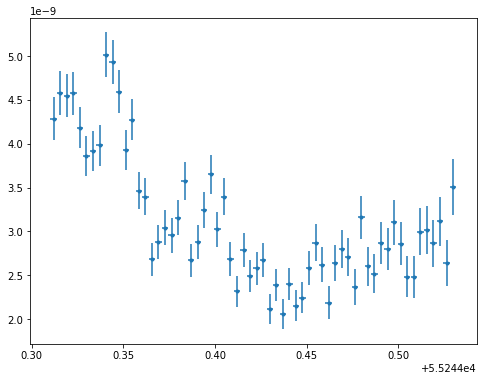

In [34]:
x,y,xerr,yerr = np.genfromtxt('ed_lc.txt',delimiter=',',dtype=str,unpack=True)

time = np.array(())
flux = np.array(())
time_err = np.array(())
flux_err = np.array(())

for i in range(len(x)):
    time = np.append(time,float(x[i].split('=')[1]))
    flux = np.append(flux,float(y[i].split('=')[1]))
    time_err = np.append(time_err,float(xerr[i].split('=')[1]))
    flux_err = np.append(flux_err,float(yerr[i].split('=')[1]))
    
mjd = np.linspace(55244.312,55244.530,62)
plt.figure(figsize=(8, 6))
plt.errorbar(mjd,flux,yerr=flux_err,xerr=time_err,ls='',marker='.')

In [35]:
t = Time(mjd, format='mjd')
"""for i in t:
    print(i)"""
iso_t = t.iso

# Overlay LC from paper

55244.40931


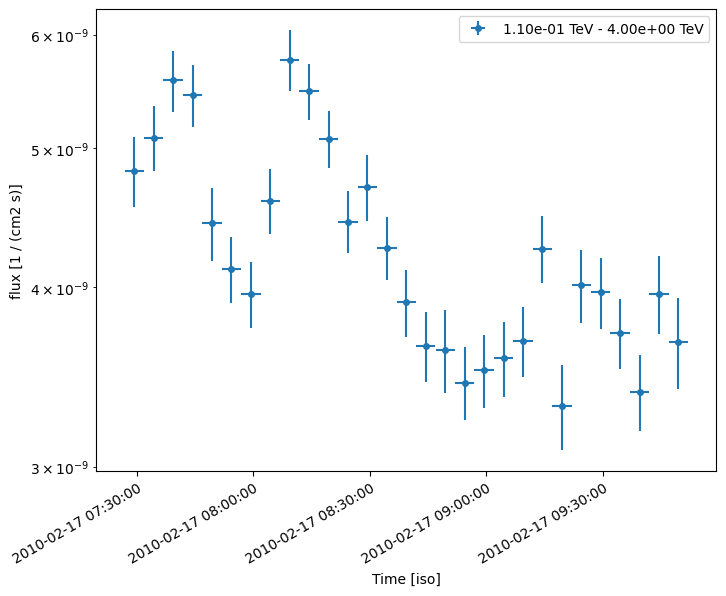

In [17]:
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
header="""# %ECSV 1.0
# ---
# datatype:
# - {name: time_min, datatype: float64}
# - {name: time_max, datatype: float64}
# - {name: e_ref, unit: TeV, datatype: string, subtype: 'float64[1]'}
# - {name: e_min, unit: TeV, datatype: string, subtype: 'float64[1]'}
# - {name: e_max, unit: TeV, datatype: string, subtype: 'float64[1]'}
# - {name: flux, unit: 1 / (cm2 s), datatype: string, subtype: 'float64[1]'}
# - {name: flux_err, unit: 1 / (cm2 s), datatype: string, subtype: 'float64[1]'}
# - {name: ts, unit: '', datatype: string, subtype: 'float64[1]'}
# - {name: sqrt_ts, unit: '', datatype: string, subtype: 'float64[1]'}
# - {name: npred, unit: '', datatype: string, subtype: 'float64[1,44]'}
# - {name: npred_excess, unit: '', datatype: string, subtype: 'float64[1,44]'}
# - {name: stat, unit: '', datatype: string, subtype: 'float64[1]'}
# - {name: is_ul, datatype: string, subtype: 'bool[1]'}
# - {name: counts, unit: '', datatype: string, subtype: 'float64[1,44]'}
# - {name: success, unit: '', datatype: string, subtype: 'bool[1]'}
# schema: astropy-2.0
time_min time_max e_ref e_min e_max flux flux_err ts sqrt_ts npred npred_excess stat is_ul counts success"""

with open("temptest.ecsv", "w") as myfile:
    myfile.write(header)

filename = "VER-000049-lc-6.ecsv"

imp_tab=Table.read("VER-000049-lc-6.ecsv")
imp_tab["e_max"]=imp_tab["e_cut"]
imp_tab["e_ref"]=np.exp(np.log(imp_tab["e_min"])+np.log(imp_tab["e_max"])/2)

imp_tab["time_min"]=imp_tab["e_cut"]
imp_tab["time_max"]=imp_tab["time"]+(imp_tab["time_bin"]/2.01)
imp_tab["time_min"]=imp_tab["time"]-(imp_tab["time_bin"]/2.01)

print(imp_tab["time"][-1])

extend="[[NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN]] [[NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN]] [0.0] [false] [[NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN]] [true]"
#for i in range(len(imp_tab)):
for i in range(len(imp_tab)):

    with open("temptest.ecsv", "a") as myfile:
        myfile.write(f'\n{imp_tab[i]["time_min"]} {imp_tab[i]["time_max"]} [{imp_tab[i]["e_ref"]}] [{imp_tab[i]["e_min"]}] [{imp_tab[i]["e_max"]}] [{imp_tab[i]["flux"]}] [{imp_tab[i]["flux_err"]}] [0] [0] {extend}')


from gammapy.estimators import FluxPoints
lc_test=FluxPoints.read('temptest.ecsv',reference_model=spectral_model,sed_type='flux',format='lightcurve')
plt.figure(figsize=(8, 6))
lc_test.plot(sed_type='flux',marker="o")
plt.show()

28


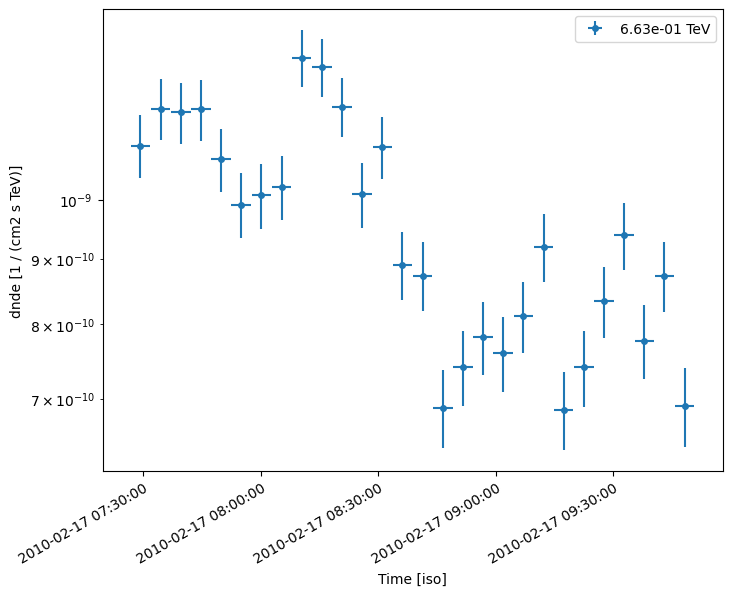

In [19]:
with open("temptest2.ecsv", "w") as myfile:
    myfile.write(header)

filename = "ED_output.ecsv"

imp_tab=Table.read("ED_output.ecsv")
imp_tab["e_max"]=imp_tab["e_cut"]
imp_tab["e_ref"]=np.exp(np.log(imp_tab["e_min"])+np.log(imp_tab["e_max"])/2)

#imp_tab["time_min"]=imp_tab["e_cut"]
imp_tab["time_max"]=imp_tab["time"]+(imp_tab["time_bin"]/2.01)
imp_tab["time_min"]=imp_tab["time"]-(imp_tab["time_bin"]/2.01)

extend="[[NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN]] [[NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN]] [0.0] [false] [[NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN]] [true]"
#for i in range(len(imp_tab)):

ind = np.where(imp_tab["time"]>55244.40931)[0][0]
print(ind)
for i in range(ind):

    with open("temptest2.ecsv", "a") as myfile:
        myfile.write(f'\n{imp_tab[i]["time_min"]} {imp_tab[i]["time_max"]} [{imp_tab[i]["e_ref"]}] [{imp_tab[i]["e_min"]}] [{imp_tab[i]["e_max"]}] [{imp_tab[i]["flux"]}] [{imp_tab[i]["flux_err"]}] [0] [0] {extend}')


from gammapy.estimators import FluxPoints
lc_test2=FluxPoints.read('temptest2.ecsv',reference_model=spectral_model,sed_type='flux',format='lightcurve')
plt.figure(figsize=(8, 6))
lc_test2.plot(sed_type='dnde',marker="o")
plt.show()

Finally we plot the result for the 1D lightcurve:




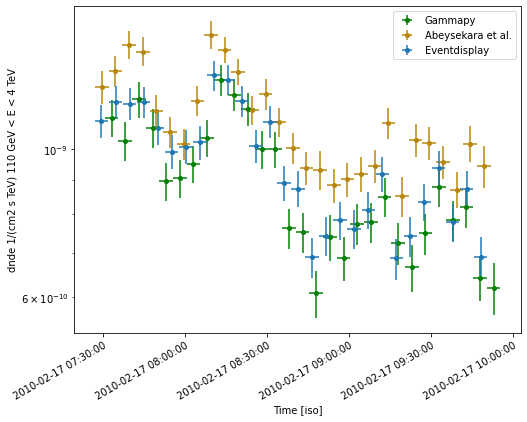

In [38]:
plt.figure(figsize=(8, 6))
lc_1d.plot(marker="o",color='g',label='Gammapy')
lc_test.plot(sed_type='dnde',marker="o",color='darkgoldenrod',label='Abeysekara et al.')
lc_test2.plot(sed_type='dnde',marker="o",label='Eventdisplay')
plt.ylabel('dnde 1/(cm2 s TeV) 110 GeV < E < 4 TeV')
plt.show()

# Extract light curve points + export to file

In [39]:
out = lc_1d.to_table(sed_type='dnde',format='lightcurve')
display(out)
out.write('421_2010_values.ecsv', overwrite=True)  

time_min,time_max,e_ref,e_min,e_max,dnde,dnde_err,ts,sqrt_ts,npred,npred_excess,stat,is_ul,counts,success
,,TeV,TeV,TeV,1 / (cm2 s TeV),1 / (cm2 s TeV),,,,,,,,
float64,float64,float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],"float64[1,34]","float64[1,34]",float64[1],bool[1],"float64[1,34]",bool[1]
55244.31284601852,55244.31631824074,0.66332495807108,0.11000000000000001,4.0,1.1144354735951685e-09,7.135473866496667e-11,1245.7273691397236,35.29486321180072,248.0621885881977 .. nan,246.00704956054688 .. nan,1.7492786471337425,False,248.0 .. nan,True
55244.31631824074,55244.319790462956,0.66332495807108,0.11000000000000001,4.0,1.0281009403273903e-09,6.857088214048522e-11,1130.8871086113875,33.6286649840785,nan .. nan,nan .. nan,11.702808984503678,False,nan .. nan,True
55244.319790462956,55244.32326268518,0.66332495807108,0.11000000000000001,4.0,1.187447099268626e-09,7.375940877800058e-11,1281.255594180663,35.79463080101068,nan .. nan,nan .. nan,7.119829807798176,False,nan .. nan,True
55244.32326268518,55244.3267349074,0.66332495807108,0.11000000000000001,4.0,1.0769091846274004e-09,7.25865673861122e-11,1114.1809328785666,33.37934889836179,nan .. nan,nan .. nan,23.299780891097853,False,nan .. nan,True
55244.3267349074,55244.33020712963,0.66332495807108,0.11000000000000001,4.0,8.951028968444256e-10,5.821137469176222e-11,1132.4641232977688,33.652104292269286,nan .. nan,nan .. nan,4.293361519538294,False,nan .. nan,True
55244.33020712963,55244.33367935185,0.66332495807108,0.11000000000000001,4.0,9.035912851111392e-10,5.857776902744893e-11,1106.899953646201,33.27010600593574,nan .. nan,nan .. nan,8.596704316578554,False,nan .. nan,True
55244.33367935185,55244.33715157407,0.66332495807108,0.11000000000000001,4.0,9.488883629866853e-10,6.011564769993067e-11,1147.0655316109903,33.868355903571555,nan .. nan,nan .. nan,4.162999979329783,False,nan .. nan,True
55244.33715157407,55244.34062379629,0.66332495807108,0.11000000000000001,4.0,1.0389919458335315e-09,6.742844604392691e-11,1136.3620454956315,33.70996952676806,nan .. nan,nan .. nan,12.971195778097657,False,nan .. nan,True


# Fit to flux points

## Custom exponential function to match paper

$F(t) = A \times exp[\frac{|t − t_{peak}|}{t_{rise,decay}}]$

In [26]:
from gammapy.data import Observation, observatory_locations
from gammapy.datasets import Datasets, FluxPointsDataset, SpectrumDataset
from gammapy.estimators import LightCurveEstimator
from gammapy.irf import load_cta_irfs
from gammapy.makers import SpectrumDatasetMaker
from gammapy.maps import MapAxis, RegionGeom, TimeMapAxis
from gammapy.modeling import Fit
from gammapy.modeling.models import (
    ExpDecayTemporalModel,
    PowerLawSpectralModel,
    SkyModel,
)

In [32]:
from gammapy.modeling import Parameter
from gammapy.modeling.models import TemporalModel


class CustomExponential(TemporalModel):
    """Custom exponential function to match https://arxiv.org/pdf/2002.03567

    Parameters
    ----------
    amplitude : `astropy.units.Quantity`
        Amplitude of the spectra model.
    tdecay : `astropy.units.Quantity`
        Halving time or Doubling rime. Negative value indicates halving time.
    tpeak : `astropy.units.Quantity`
        Time at peak energy.

    """

    tag = "CustomExponential"
    amplitude = Parameter("amplitude", "5.5e-9 cm-2 s-1 TeV-1", min=0, is_norm=True)
    tdecay = Parameter("tdecay", -28*u.min)
    tpeak = Parameter("tpeak", 18*u.min)

    @staticmethod
    def evaluate(time,amplitude,tdecay,tpeak):
        return amplitude * np.exp(np.abs(time-tpeak)/tdecay)

In [33]:
from gammapy.modeling import Fit

# Create the datasets by iterating over the returned lightcurve
datasets = Datasets()

for idx, fp in enumerate(lc_1d.iter_by_axis(axis_name="time")):
    dataset = FluxPointsDataset(data=fp, name=f"time-bin-{idx}")
    datasets.append(dataset)

In [34]:
# Define the model:
spectral_model1 = PowerLawSpectralModel(
    index=-2.0, amplitude="5e-9 cm-2 s-1 TeV-1", reference="1 TeV"
)
temporal_model1 = CustomExponential(amplitude="5.5e-9 cm-2 s-1 TeV-1",tdecay=-28*u.min,tpeak=18*u.min)

model = SkyModel(
    spectral_model=spectral_model1,
    temporal_model=temporal_model1,
    name="model-test",
)

datasets.models = model

AttributeError: 'CustomExponential' object has no attribute 'integral'

In [108]:
fit = Fit()
result = fit.run(datasets=datasets)
display(result.parameters.to_table())

plt.show()

/homes/wang/swong/.local/lib/python3.9/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/homes/wang/swong/.local/lib/python3.9/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


type,name,value,unit,error,min,max,frozen,is_norm,link
str8,str9,float64,str14,float64,float64,float64,bool,bool,str1
spectral,index,-2.0000e+00,,1.000e+00,nan,nan,False,False,
spectral,amplitude,5.0000e-09,cm-2 s-1 TeV-1,1.000e+00,nan,nan,False,True,
spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,
temporal,t0,8.4000e+01,min,1.000e+00,nan,nan,False,False,
temporal,t_ref,5.1544e+04,d,0.000e+00,nan,nan,True,False,


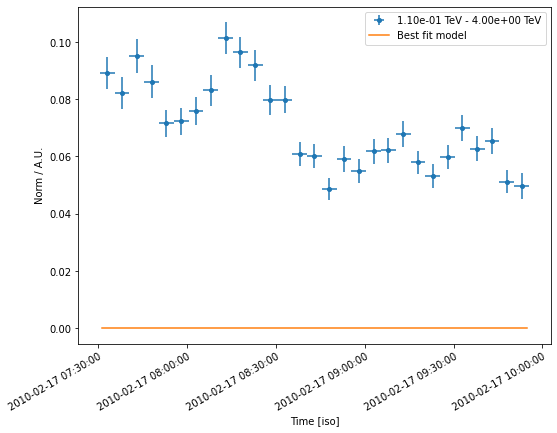

In [109]:
fig, ax = plt.subplots(
    figsize=(8, 6),
    gridspec_kw={"left": 0.16, "bottom": 0.2, "top": 0.98, "right": 0.98},
)
lc_1d.plot(ax=ax, sed_type="norm", axis_name="time")


time_range = lc_1d.geom.axes["time"].time_bounds
temporal_model1.plot(ax=ax, time_range=time_range, label="Best fit model")

ax.set_yscale("linear")
ax.legend()